### Домашнее задание - Латентное пространство в VAE автоенкодере

Лучше всего читать оригинальные работы - обычно они очень хорошо и подробно написаны.  
Рекомендую прочитать оригинальную статью [Variational AutoEncoder](https://arxiv.org/pdf/1312.6114.pdf) (VAE, D.P. Kingma et. al., 2013)

В данном задании необходимо:

1. Реализовать обычный автоенкодер и VAE автоенкодер с архитектурой как на рисунке:
<img src='images/mnist_vae.png' width=300>

2. Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство, получить рисунок похожий на рисунок ниже для обоих автоенкодеров и сравнить результаты:
<img src='images/vae_mnist_cloud.png' width=300>

3. Построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='images/vae_mnist_digits.png' width=300>

4. (*) Скачать датасет со знаменитостями [celebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) и повторить для него, предварительно (если нужно) сократив размеры картинок, чтобы ускорить работу. Поэкспериментировать с модификацией изображений лиц - например, добавляя очки или изменяя цвет волос.
<img src='images/celeA_intro.png' width=300>

**Замечание** Для того, чтобы реализовать VAE, прочитайте данную ниже небольшаую теоретическую справку и выполните задание в конце.

### Кроссэнтропия
В теории информации перекрёстная энтропия (или *кроссэнтропия*) между двумя распределениями вероятностей измеряет среднее число бит, необходимых для опознания события из набора возможностей, если используемая схема кодирования базируется на заданном распределении вероятностей $q$, вместо «истинного» распределения $p$.  
Кроссэнтропией распределения $q$ по отношению к распределению $p$ называется величина:  
$$H(p, q) \stackrel{\mathrm{df}}{\;=\;} \mathrm{E}_p[-\log q] = -\sum_x p(x)\, \log q(x) = H(p) + D_{KL}(p \| q),$$  
<!-- или  $$H(p, q) = -\int\limits_X p(x)\, \log q(x)\, dx.$$ -->
где $H(p)$ - энтропия распределения $p$, $D_{KL}(p \| q)$ - дивергенция Кульбака-Лейблера. Можно показать, что энтропия $H(p)$ всегда меньше чем кроссэнтропия $H(p, q)$. Таким образом, дивергенция Кульбака-Лейблера - неотрицательная величина.



### Дивергенция Кульбака-Лейблера
Расхождение (дивергенция) Ку́льбака-Ле́йблера (англ. Kullback–Leibler divergence), РКЛ, — информационное расхождение, различающая информация, информационный выигрыш, относительная энтропия (англ. relative entropy). Это неотрицательнозначный функционал, являющийся несимметричной мерой удалённости друг от друга двух вероятностных распределений $p$ и $q$, определённых на общем пространстве элементарных событий:  
$$D_{\mathrm{KL}}(p\parallel q) = \sum_x p(x) \, \log \frac{p(x)}{q(x)} \,$$

### Дивергенция Кульбака-Лейблера для многомерного нормального распределения
Допустим, что мы имеем два многомерных нормальных распределения, со средними $\mu_0, \mu_1$ и с (обратимыми) матрицами ковариаций $\Sigma_0, \Sigma_1$. Если два распределения имеют одинаковую размерность $k$, то РКЛ между распределениями следующее:  
$$D_\text{KL}(\mathcal{N}_0 \parallel  \mathcal{N}_1) = { 1 \over 2 } \left( \mathrm{tr} \left( \Sigma_1^{-1} \Sigma_0 \right) + \left( \mu_1 - \mu_0\right)^\top \Sigma_1^{-1} ( \mu_1 - \mu_0 ) - k + \ln \left( { \det \Sigma_1 \over \det \Sigma_0  } \right)  \right).$$


Упростите данное выражение для случая, которое используется в VAE, когда компоненты векторов независимы, т.е. матрицы ковариации диагональны. Также упростите выражение, когда второе распределение $\mathcal{N}_1$ является стандартным, т.е. с нулевыми средними и единичными дисперсиями.

### Загрузка данных MNIST

In [19]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
INPUT_SIZE = 784
BATCH_SIZE = 100

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1000, 
                                          shuffle=False)


## MNIST автоенкодер

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size), 
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size, latent_size)
                                  )
    def forward(self, X):
        return self.model(X)

    
class Decoder(nn.Module):
    def __init__(self,  input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.model = nn.Sequential(nn.Linear(latent_size, hidden_size),
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size, input_size)
                                  )
    def forward(self, X):
        return self.model(X)
    
    
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.encoder = Encoder(input_size, latent_size, hidden_size)
        self.decoder = Decoder(input_size, latent_size, hidden_size)
        
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent)

In [3]:
model1 = Autoencoder(input_size=INPUT_SIZE, latent_size=2).to(device)

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)  

# Train the model
num_epochs = 50
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images.to(device)
        #labels = labels.to(device)
        
        # Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, loss.item()))
# torch.save(model.state_dict(), 'model.ckpt')

Epoch [10/50], Loss: 0.0423
Epoch [20/50], Loss: 0.0353
Epoch [30/50], Loss: 0.0388
Epoch [40/50], Loss: 0.0395
Epoch [50/50], Loss: 0.0389


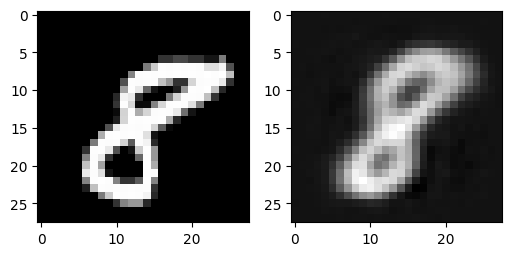

tensor(8)


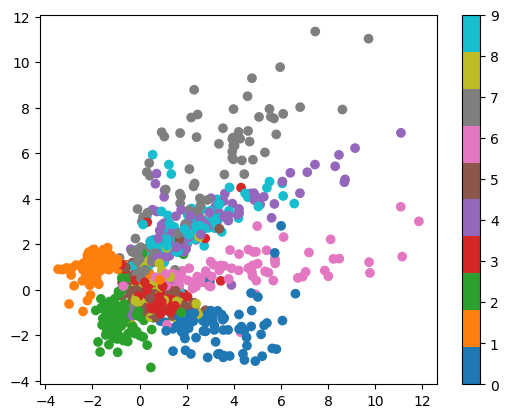

In [6]:
for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output = model1(images)
images = images.cpu()
output = output.cpu()

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
latent = model1.encoder(images)
latent = latent.cpu()
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

## Регуляризация автоенкодера

In [7]:
class Autoencoder_latent(nn.Module):
    def __init__(self, input_size, latent_size, hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.encoder = Encoder(input_size, latent_size, hidden_size)
        self.decoder = Decoder(input_size, latent_size, hidden_size)
        
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent), latent

In [8]:
model2 = Autoencoder_latent(input_size=INPUT_SIZE, latent_size=2).to(device)

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)  
LAMBDA = 0.1
# Train the model
num_epochs = 50
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images.to(device)
        #labels = labels.to(device)
        
        # Forward pass
        outputs, latent = model2(images)
        reconstruction_loss = criterion(outputs, labels)
        regulizer_loss = (latent * latent).sum(axis=1).mean()
        
        loss = reconstruction_loss + LAMBDA/2 * regulizer_loss
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], reconstruction_loss:{:.6f}, regulizer_loss:{:.6f}, Loss: {:.4f}' 
                .format(epoch+1, num_epochs,  
                        reconstruction_loss.item(), regulizer_loss.item(), loss.item()))

Epoch [10/50], reconstruction_loss:0.044529, regulizer_loss:0.009704, Loss: 0.0450
Epoch [20/50], reconstruction_loss:0.046550, regulizer_loss:0.011370, Loss: 0.0471
Epoch [30/50], reconstruction_loss:0.046324, regulizer_loss:0.010903, Loss: 0.0469
Epoch [40/50], reconstruction_loss:0.043995, regulizer_loss:0.010337, Loss: 0.0445
Epoch [50/50], reconstruction_loss:0.044148, regulizer_loss:0.010026, Loss: 0.0446


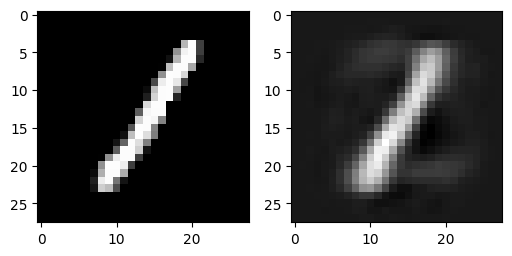

tensor(1)


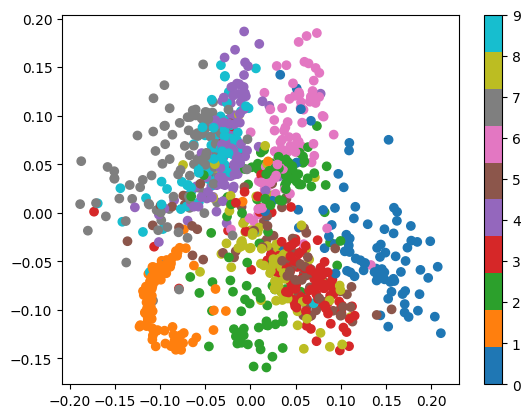

In [9]:
for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output, latent = model2(images)
images = images.cpu()
output = output.cpu()
latent = latent.cpu()

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output, latent = model2(images)
images = images.cpu()
output = output.cpu()
latent = latent.cpu()
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

In [10]:
lim = 0.15
xx = np.linspace(-lim, lim, 15)
yy = np.linspace(-lim, lim, 15)
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros((XX.size, 2)) #np.concatenate((XX[None], YY[None]), axis=0)
ZZ[:,0] = XX.flatten()
ZZ[:,1] = YY.flatten()

latent_gen = torch.FloatTensor(ZZ).to(device)
output = model2.decoder(latent_gen)
output = output.cpu()

In [11]:
images = output.detach().numpy()
big_image = np.zeros((15 * 28, 15 * 28))
for i in range(15):
    for j in range(15):
        big_image[i*28 : (i+1)*28, j*28 : (j+1)*28] = 1 - images[15*i + j].reshape(28, 28)

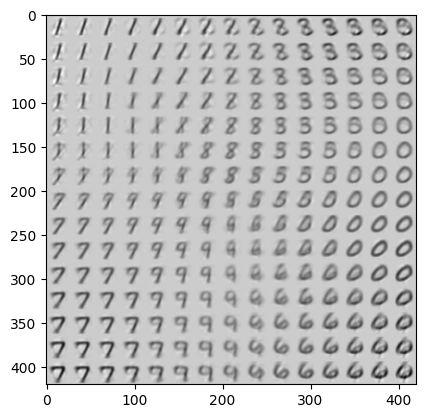

In [12]:
plt.imshow(big_image, cmap='gray')
plt.show()

## VAE автоенкодер

In [2]:
# input_size = 784 (28 x 28)
# hidden_size1 = 500
# hidden_size2 = 250
# latent_size = 2

class EncoderVAE(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.latent_size = latent_size
        
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size1), 
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size1, hidden_size2),
                                   nn.ReLU()
                                  )
        self.mean_layer = nn.Linear(hidden_size2, latent_size)
        self.var_layer = nn.Linear(hidden_size2, latent_size)
        self.kl = 0
        
    def forward(self, X):
        X1 = self.model(X)
        mean = self.mean_layer(X1)
        var = torch.exp(0.5 * self.var_layer(X1))
        eps = torch.randn_like(var)
        lat = mean + var * eps
        self.kl = - 0.5 * (1 + torch.log(var ** 2) - mean ** 2 - var ** 2).sum()
        return lat

    
class DecoderVAE(nn.Module):
    def __init__(self,  input_size, hidden_size1, hidden_size2, latent_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.latent_size = latent_size

        self.model = nn.Sequential(nn.Linear(latent_size, hidden_size2),
                                   nn.ReLU(), 
                                   nn.Linear(hidden_size2, hidden_size1),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size1, input_size)
                                  )
    def forward(self, X):
        return self.model(X)
    
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.latent_size = latent_size
        self.encoder = EncoderVAE(input_size, hidden_size1, hidden_size2, latent_size)
        self.decoder = DecoderVAE(input_size, hidden_size1, hidden_size2, latent_size)
        
    def forward(self, X):
        latent = self.encoder(X)
        return self.decoder(latent)

In [3]:
model3 = VariationalAutoencoder(input_size = 784, hidden_size1 = 500, hidden_size2 = 250, latent_size = 2).to(device)

# loss
criterion = nn.MSELoss(reduction = "sum")

# optimizer
optimizer = torch.optim.Adam(model3.parameters())  

# Train the model
num_epochs = 100
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28 * 28).to(device)
        labels = images.to(device)
        
        outputs = model3(images)
        loss_r = criterion(outputs, labels)
        loss = loss_r + model3.encoder.kl
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, loss.item()))

Epoch [10/100], Loss: 3413.9968
Epoch [20/100], Loss: 3494.8228
Epoch [30/100], Loss: 3176.5886
Epoch [40/100], Loss: 3456.0845
Epoch [50/100], Loss: 3227.6335
Epoch [60/100], Loss: 3332.9451
Epoch [70/100], Loss: 3417.9902
Epoch [80/100], Loss: 3155.4189
Epoch [90/100], Loss: 2933.0625
Epoch [100/100], Loss: 3488.6914


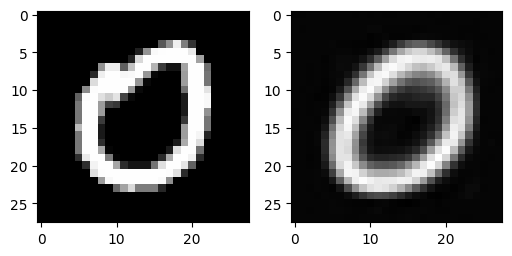

tensor(0)


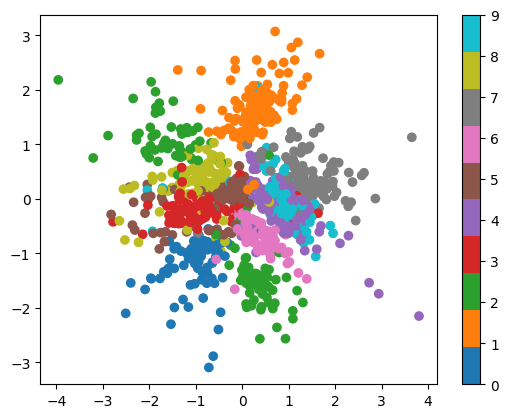

In [5]:
for (images, labels) in train_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
output = model3(images)
images = images.cpu()
output = output.cpu()

orig_img = images[0].detach().numpy().reshape(28, 28)
img = output[0].detach().numpy().reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(6, 12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(img, cmap='gray')
plt.show()
print(labels[0])

for (images, labels) in test_loader:
    break
images = images.reshape(-1, 28 * 28).to(device)
latent = model3.encoder(images)
latent = latent.cpu()
latent_pepr = latent.detach().numpy()
plt.scatter(latent_pepr[:,0], latent_pepr[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

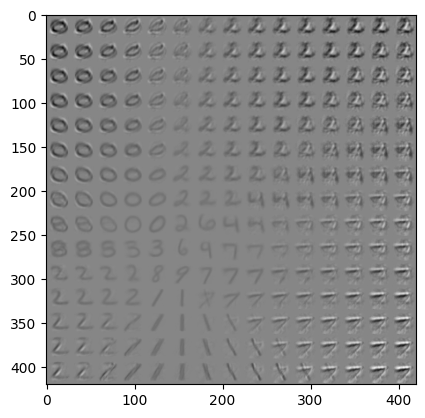

In [7]:
w = 28
n = 15
r0=(-5, 10) 
r1=(-10, 5)
img = np.zeros((n*w, n*w))
for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.Tensor([[x, y]]).to(device)
        x_hat = model3.decoder(z)
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
        img[(i)*w:(i+1)*w, j*w:(j+1)*w] = 1 - x_hat
plt.imshow(img, cmap = 'gray')